In [210]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [211]:
#np.random.seed(123)

# Hidden Markov Model Assignment

The robot can move on the cells with light background, but cannot go over the obstacles, which have the dark blue background.


### Maze definition

Here we define the robot’s environment as a 2D NumPy array.
- Each **1** represents a feasible cell where the robot can be.
- Each **0** represents an obstacle where the robot cannot move which can be called blocks or Unreachable.

This maze will be the basis for defining the states and transitions of the HMM.


In [212]:
# Use the maze corresponding to your group!
maze = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0],
    [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1],
    [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
])

### Visualizing the maze

The function `plot_maze` helps us in rawing of the  maze as a grid:
- Feasible cells are light blue.
- Obstacles or Blocks are dark blue.
- Each cell gets a unique index, which we use later to map positions to HMM states.
- Optionally, a given trajectory `Z` can be highlighted in red.

This visualization helps to understand how states relate to physical positions.



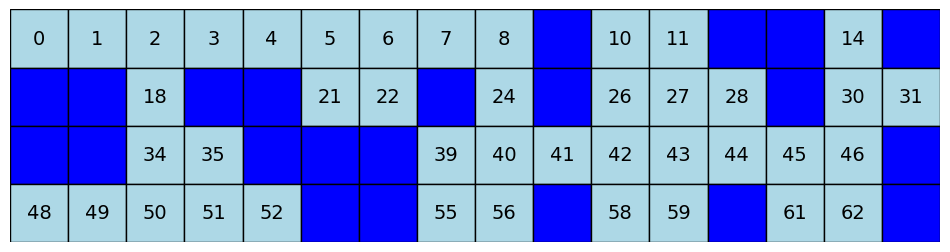

In [213]:
def plot_maze(ax, maze, skip_walls=True, Z=None):
    cell_idx = 0
    rows, cols = maze.shape
    for r in range(rows):
        for c in range(cols):
            color = 'lightblue' if maze[r, c] == 1 else 'blue'

            if Z is not None and (r * cols + c) in Z:
                color = 'red'

            ax.add_patch(patches.Rectangle((c, rows - 1 - r), 1, 1, edgecolor='black', facecolor=color))
            if maze[r, c] == 1 or not skip_walls:
                ax.text(c + 0.5, rows - 1 - r + 0.5, str(cell_idx), color='black', ha='center', va='center',
                        fontsize=14)
            cell_idx += 1

    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)

    ax.set_aspect('equal')
    ax.axis('off')


fig, ax = plt.subplots(figsize=(12, 9))

plot_maze(ax, maze)

### Defintion of the states
the states are a list of all the posssibile cells (rows, columns)which are flessibile of thr maze matrix / grid , which the robot can naigate through.

In [214]:
# Suggested names for possible states
rows, cols = maze.shape
states = [(r, c) for r in range(rows) for c in range(cols) if maze[r, c]]  # 42 feasible states


### Observation vocabulary
 Suggested names for the possible observations.The robot’s sensor reads which directions (N, S, E, W) are feasible from the current cell.
There are \(2^4 = 16\) possible combinations, so we build a **vocabulary** of 16 observation symbols:

- Each symbol corresponds to a 4-bit pattern (N, S, E, W).
- For example, (NE) means “North and East are free; South and West are blocked”.

In [215]:
# Suggested names for the possible observations. If can be seen as a binary digit from 0 to 15, where the least significant bit indicates West.
# This may be usefule to code the emission matrix
letters = ['N', 'S', 'E', 'W']
vocabulary = []
for i in range(2 ** len(letters)):  # observations can be indexed with numbers 0 to 15
    binary = format(i, '04b')  # 4-bit format interpreted as possibility to move N,S,E,W
    combination = ''.join([letters[j] for j in range(4) if binary[j] == '1'])
    combination = '(' + combination + ')'
    vocabulary.append(combination)

In [216]:
vocabulary

['()',
 '(W)',
 '(E)',
 '(EW)',
 '(S)',
 '(SW)',
 '(SE)',
 '(SEW)',
 '(N)',
 '(NW)',
 '(NE)',
 '(NEW)',
 '(NS)',
 '(NSW)',
 '(NSE)',
 '(NSEW)']

## 1 HMM Definition and Trajectory Generation

### 1.1 Transition probability definition

Define the *transition probability matrix* $A$ corresponding to the robot maze. Consider that:

* The robot can only reach a neighboring cell.
* The robot can move North, South, East, West.
* Diagonal moves are not allowed.
* Passing over obstacles is not allowed.
* Feasible transitions are equally probable.

In [217]:
def create_path_matrix(maze):
    rows, cols = maze.shape
    f_len = rows * cols
    A = np.zeros((f_len, f_len))
    B = np.zeros((f_len, 2 ** len(letters)))

    arr = maze.flatten()

    # N,S,E,W
    for i in range(f_len):
        code = 0
        if arr[i] == 0:
            continue
        if (i + 1) % cols and arr[i + 1] == 1:  # E
            A[i, i + 1] = 1
            code += 2
        if i % cols and arr[i - 1] == 1:  # W
            A[i, i - 1] = 1
            code += 1
        if i + cols < f_len and arr[i + cols] == 1:  # S
            A[i, i + cols] = 1
            code += 4
        if i - cols >= 0 and arr[i - cols] == 1:  # N
            A[i, i - cols] = 1
            code += 8
        B[i][code] = 1
        pths = A[i, :].sum()
        if pths != 0:
            A[i, :] = A[i, :] / pths
    return A, B

In [218]:
A, B = create_path_matrix(maze)
print(A.shape)

(64, 64)



**A)** Transition matrix A:
    What next state is possible from here? (movement)
Basically the transistion matrix helps to tells us in what  state the  robot is in ,what the % chance to move a flessibile cell(state).
So the transistion matrix is made up of the entire states of the maze  but of flessible states & states which are flessible.

**B)** Emission matrix B:
    What observation is likely from this state? (sensor)

Emission matrix  helps to tell what is the likely observation  y , when  the robot is in a state .
Row = state  , column = observations

B[i,y] = probability that the sensor returns observation y when the robot is in state i.


There are 16 possible observations because:
 * they are 4 directions  -> each be  0 or 1 => 2^4 = 16

So the emission  matrix B  would have a size of  number of states  x 16 (number of observation)

Additional info : ```arr = maze.flatten()```
helps to turn the maze into a single array.

So code is an integer from 0 to 15 that encodes which directions are open.

```pths``` counts how many outgoing neighbors exist from state i , if  at least one neighbours exist  we dived the row by pths , this makes all outgoing transitions to have a equal likely probability  over the neighbours


### 1.2 Emission probability definition

Define the *emission probability matrix* $B$.
* After each move, the robot senses whether the cells to the North, South, East, West are feasible.
* There are 16 possible observations (previously defined variable `vocabulary`).

In [219]:
print(B.shape)
print(B)

(64, 16)
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 1.3 Trajectory Sampling

Sample and visualize a state and observation sequences $Z$ and $Y$ of
length $T = 20$ compatible with the previous hypotheses.

* Use the previously defined transition and emission matrices
* Consider the initial position equiprobable among the admissible states


So since the robot have an equal probability of starting any  cell in the intital  case / start , for probability calculations. We then count the number of feasible cells (cells with value 1) in the entire maze. Then we normalize the start_prob matrix by dividing each element by the total number of feasible cells. This ensures that the sum of all probabilities in the `start_prob` matrix **equals 1**, making it a valid probability distribution over the entire grid.

In [220]:
start_prob = maze.copy()
row_counts = np.count_nonzero(start_prob == 1, axis=1)
total_feasible = int(start_prob.sum())

print("moveable cell per row:", row_counts)
print("totale moveable cell:", total_feasible)

# normalizaing to obtain an  distribution of probability in our grid
start_prob = start_prob / start_prob.sum()

moveable cell per row: [12  9 10 11]
totale moveable cell: 42


In [221]:
def pick_random_start(start_prob):
    array = start_prob.flatten()
    return np.random.choice(range(len(array)), p=array)

In [222]:
t = 20
Z = np.zeros(t, dtype=int)
Y = np.zeros(t, dtype=int)

In [223]:
Z[0] = pick_random_start(start_prob)


A) Traverse the state sequence Z according to the transition matrix A.
for each time step i from 1 to t-1:
* We look at the previous state Z[i-1]
* Use the correspondind row of the transistion matrix A , A[Z[i-1]] to iterate (sample) over to the next state
* Then we store in the Z[i] the sampled state

B)The observation matrix Y is built according to the emission matrix B.
* These numbers go from 0 to 15.
* Use row B[Z[i]] as the emission distribution to sample an observation.

* Store in Y[i], which tells what sensors is read at that cell  , this helps us  tell which direction (vocabulary ) around is  free for  movement..

In [224]:
def traverse_z(Z, A):
    for i in range(1, t):
        Z[i] = np.random.choice(range(A.shape[0]), p=A[Z[i - 1]])


def build_y(Z, Y, B):
    for i in range(t):
        Y[i] = np.random.choice(range(16), p=B[Z[i]])

[ 3  4  3  4  3  2  1  0  1  0  1  0  1  2 18  2  3  4  3  2]
[ 3  3  3  3  3  7  3  2  3  2  3  2  3  7 12  7  3  3  3  7]
['(EW)', '(EW)', '(EW)', '(EW)', '(EW)', '(SEW)', '(EW)', '(E)', '(EW)', '(E)', '(EW)', '(E)', '(EW)', '(SEW)', '(NS)', '(SEW)', '(EW)', '(EW)', '(EW)', '(SEW)']


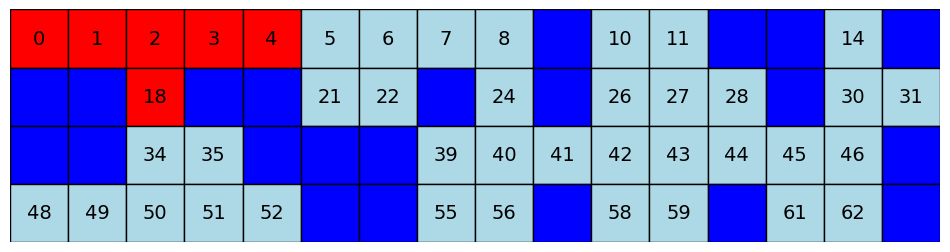

In [225]:
traverse_z(Z, A)
print(Z)
build_y(Z, Y, B)
print(Y)
print(list(map(vocabulary.__getitem__, Y)))

fig, ax = plt.subplots(figsize=(12, 9))
plot_maze(ax, maze, Z=Z)

## 2 Decoding and inference

### 2.1 Likelihood
1
Compute the likelihood of the obtained observation sequence $Y$.

In [226]:
def likelihood_calc(A, B, Y, pi):
    alpha = np.zeros((len(Y), len(B)))
    alpha[0] = pi.flatten() * B[:, Y[0]]
    for t in range(1, len(Y)):
        alpha[t] = B[:, Y[t]] * (alpha[t - 1] @ A)
    return alpha, alpha[-1].sum()


alpha, likelihood = likelihood_calc(A, B, Y, start_prob)
likelihood

1.0764577821869488e-07

To create the likelihood calculation ,alpha matrix which helps store our forward probabilities (of our HMM )at each time step for each state, it should have shape T x N (N = length of B). So now we are going to apply the formula seem in class : **Initialization: α₁(j) = πⱼ bⱼ(y₁)** , then in the second block with loop we apply recursive formula : **αₜ(j) = Σᵢ₌₁ᴺ αₜ₋₁(i) aᵢⱼ bⱼ(yₜ)**
then lastly in  the output ``` alpha[-1].sum()``` : the total likelihood  P(Y), the sum of all alpha[T-1, j] which basically the  application this formula **P(Y) = Σᵢ₌₁ᴺ α_T(i)**.


### 2.1 Decoding 

Obtain the most probable state sequence, given the observation sequence $Y$.We will consider the *decoding* problem for HMMs, i.e., given a sequence of observations $Y = y_1, \ldots, y_T$, we want to find the most probable sequence of hidden states $Z = z_1, \ldots, z_T$ that could have generated the observations. In particular, we want to find

$$ \hat Z = \arg \max_Z P(Z \mid Y) $$

In the maze localization problem:
- States $z_t$ represent the robot's **true cell positions**
- Observations $y_t$ represent **sensor readings** (open directions)
- The goal is to infer the **single most probable path** of the robot

In [227]:
def viterbi(A, B, Y, pi):
    v = np.zeros((len(Y), len(B)))
    back = np.zeros((len(Y), len(B)), dtype=int)
    v[0] = pi.flatten() * B[:, Y[0]]
    back[0].fill(-1)

    for t in range(1, len(Y)):
        for j in range(len(B)):
            scores = v[t - 1] * A[:, j]
            best_prev = np.argmax(scores)
            v[t][j] = B[j][Y[t]] * scores[best_prev]
            back[t][j] = best_prev

    path = np.zeros(len(Y), dtype=int)
    path[-1] = np.argmax(v[-1])

    for i in range(len(Y) - 2, -1, -1):
        path[i] = back[i + 1][path[i + 1]]

    return v, path


v, path = viterbi(A, B, Y, start_prob)

print(path, 'most possible path')
print(Z, 'actual path')

[ 3  4  3  4  3  2  1  0  1  0  1  0  1  2 18  2  3  4  3  2] most possible path
[ 3  4  3  4  3  2  1  0  1  0  1  0  1  2 18  2  3  4  3  2] actual path


This function implements the Viterbi algorithm to find the most probable sequence of hidden states (path) given an observation sequence \(Y\). The algorithm uses dynamic programming to efficiently compute the highest probability of any path that ends in each state at each time step.
The function initializes two matrices: `v` for storing the maximum probabilities and `back` for backtracking the most probable path. At first initializes the first column of `v` using the initial state distribution \(pi\) and the emission probabilities for the first observation. Secondly set of nested loops iteratively fills in the `v` and `back` matrices by calculating the maximum probability of reaching each state at each time step, considering all possible previous states.
After filling in the matrices, the function backtracks from the last time step to reconstruct the most probable path of states.

### Formulars applied from class
#### Viterbi recursion

Define the Viterbi score:$$v_t(j) = \max_{z_0,\dots,z_{t-1}} P(z_0,\dots,z_{t-1}, z_t=j, y_0,\dots,y_t)$$
**Initialization ($t=0$):** $$ v_0(j) = \pi(j)\,B[j, y_0] $$
**Recursion ($t \ge 1$):** $$ v_t(j) = B[j, y_t] \cdot \max_i \left( v_{t-1}(i)\,A[i,j] \right)$$
**Backpointer:** $$\text{back}_t(j) = \arg\max_i \left( v_{t-1}(i)\,A[i,j] \right) $$

#### Path reconstruction (backtracking)

1) Final state: $$ z_T^* = \arg\max_j v_T(j) $$

2) Backtrack for $t = T-1, \dots, 1$:
$$ z_{t-1}^* = \text{back}_t(z_t^*) $$
This yields the most likely hidden state sequence $(z_0^*, z_1^*, \dots, z_T^*)$.


### Final

At each time step, for each candidate state $j$, Viterbi:
1. considers all possible previous states $i$
2. keeps only the best incoming path (the max over $i$)
3. multiplies by the observation likelihood $B[j, y_t]$

In the noiseless sensor case, $B[j,y_t]$ is typically 0 or 1:
- if the observation matches state $j$, the path survives
- otherwise the probability becomes 0 and the state is eliminated

### 2.2 Filtering

Obtain the filtering distribution $P(z_t \mid y_{1:t})$ at each time step $t$.

In [228]:
def filtering(A, B, Y, pi):
    alpha, _ = likelihood_calc(A, B, Y, pi)
    return alpha / alpha.sum(axis=1, keepdims=True)


props_t = filtering(A, B, Y, start_prob)
props_t

array([[0.        , 0.16666667, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ]])

The filtering is used to compute the posterior distribution over the hidden states at each time step, given all observations up to that time. The function `filtering` first computes the forward probabilities (α alpha) using the `likelihood_calc` function. Then, it normalizes these probabilities row-wise to obtain valid probability distributions for each time step. The normalization, ensures that each row of the resulting matrix sums to 1. The output `props_t` contains the filtering distributions $P(z_t \mid y_{0:t})$ for each time step (t).

* It estimates **where the robot is now**, given all past sensor readings
* It maintains uncertainty instead of selecting a single path

In conclusion filtering helps us  estimate the probability ditribution of the curent state of our robot , through the use of looking at previous states it , therefore keeps all possible states with their probabilities instead of just picking the most likely state like in viterbi algorithm.

### 2.3 Noisy observations

Repeat steps 2.1 and 2.2 in the presence of sensor error noise. In particular, consider that:
  * With probability $1-\epsilon$, the sensor provides the correct reading
  * With probability $\epsilon$, the sensor returns a wrong reading. 
  * The $\epsilon$ probability is equally split among all wrong readings.
  * Set $\epsilon=0.2$. Optionally, test also other values.

####  Noisy sensor model

We asked to include the sensor noise into the emission matrix,then we built a new emission matrix B called B_noisy and then:
* Sample a new noisy observation sequence Y_noisy.
* Recompute the likelihood, Viterbi path, and filtering distributions under this noisy model.
* Compare the inferred path with the true state sequence (Z).




[ 3  4  3  4  3  2  1  0  1  0  1  0  1  2 18  2  3  4  3  2] actual path
[ 3  3  3  3  3  7  3  2  3  2  3  2  3  7 12  7  3  3  3  7] actual sensory data

esp = 0.1
[ 3  3 11  1  3  7  3  2  3  2  3  2  3  7 12  7  3  3  3  7] noisy sensory data


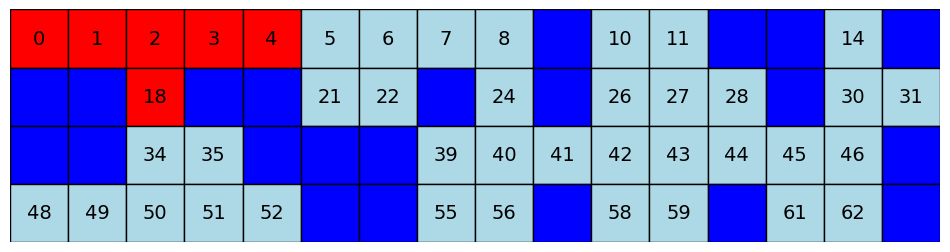

In [229]:

print(Z, 'actual path')
print(Y, 'actual sensory data')

esp = 0.1
print()
print(f'{esp = }')

B_noisy = np.zeros_like(B)
for i in range(len(B)):
    B_noisy[i] = np.array(
        [esp / (len(vocabulary) - 1) if j != np.argmax(B[i]) else 1 - esp for j in range(len(vocabulary))])

Y_noisy = np.zeros(t, dtype=int)
build_y(Z, Y_noisy, B_noisy)
print(Y_noisy, 'noisy sensory data')

fig, ax = plt.subplots(figsize=(12, 9))
plot_maze(ax, maze, Z=Z)

In [230]:
alpha, likelihood = likelihood_calc(A, B_noisy, Y_noisy, start_prob)
likelihood

2.448714488482318e-12

In [231]:
v, path = viterbi(A, B_noisy, Y_noisy, start_prob)

print(path, 'possible noisy path')
print(Z, 'actual path')

[ 3  4  3  4  3  2  1  0  1  0  1  0  1  2 18  2  3  4  3  2] possible noisy path
[ 3  4  3  4  3  2  1  0  1  0  1  0  1  2 18  2  3  4  3  2] actual path


In [232]:
props_t = filtering(A, B_noisy, Y_noisy, start_prob)
props_t

array([[1.18203310e-03, 1.59574468e-01, 1.18203310e-03, ...,
        1.18203310e-03, 1.18203310e-03, 0.00000000e+00],
       [3.45068502e-03, 9.20182673e-03, 6.92693068e-03, ...,
        4.26010497e-05, 4.26010497e-05, 0.00000000e+00],
       [2.56902470e-03, 3.21603833e-03, 1.33277671e-01, ...,
        2.29943569e-05, 2.29943569e-05, 0.00000000e+00],
       ...,
       [7.24593018e-03, 9.43411126e-12, 1.45453032e-02, ...,
        4.69364693e-22, 2.75900212e-24, 0.00000000e+00],
       [6.85576188e-14, 2.37302083e-02, 2.52584578e-11, ...,
        3.88960984e-26, 5.68775146e-24, 0.00000000e+00],
       [1.74895297e-04, 1.25116382e-13, 9.87897548e-01, ...,
        2.62565391e-25, 5.04428689e-28, 0.00000000e+00]])

where we tried these values of noises :
$\epsilon_1=0.2$ , $\epsilon_2=0.1$
We first tried noise at $\epsilon_1=0.2$ but it was too high and the results were not good for the possible path found but thanks to this we discovered that lowering the noise to 0.1($epsilon_2$) gave us better results and the noisy path was now closer to our actual path.

## 3 Analysis and discussion

Comment the techniques applied and the obtained results.

This project applied a Hidden Markov Model (HMM) to robot localization in a grid maze, implementing the three core inference tasks studied in class: likelihood computation (Forward), decoding (Viterbi), and online state estimation (filtering).
The transition model encoded the maze geometry by allowing only physically feasible moves, ensuring that inferred trajectories were always consistent with the environment. The emission model strongly constrained the state space in the noise-free case, leading to rapid uncertainty reduction. When sensor noise was introduced ($\epsilon_1=0.2$ , $\epsilon_2=0.1$), the robot becomes less sure about where it is. The observation likelihoods decreased and sensor reading can now match several different positions, not just one. So now the model assigns smaller probabilities to each position and spreads its belief over many possible locations instead of focusing on a single one.
Viterbi decoding produced a physically plausible trajectory closely matching the true path, with minor errors when different locations in the maze look identical to the sensors. When this happens, the algorithm can choose the wrong position even though it is still a valid move.
Filtering complemented this by providing full belief distributions, explicitly revealing uncertainty, especially under noisy sensing (more noise => more uncertainty).
Overall, the results highlight the effectiveness of probabilistic HMM inference for localization and demonstrate why probabilistic reasoning is essential for robust operation in the presence of sensor noise.



### Conclusion

The implementation demonstrates that HMMs provide a principled approach to sequential inference in robotics. Forward enables efficient likelihood computation, Viterbi yields a globally consistent best path, and filtering provides an interpretable measure of uncertainty over time. The contrast between noise-free and $\epsilon_1=0.2$ & $\epsilon_2=0.1$  noisy sensing highlights the importance of probabilistic reasoning in realistic scenarios.
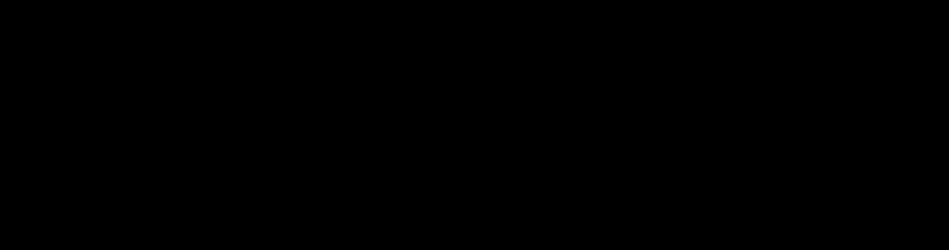